# Step 4: Multi-Label Service Type Classification

This notebook builds a **multi-label classifier** to predict service types. Unlike single-label classification where each service gets ONE label, multi-label allows predicting MULTIPLE types per service.

**22 Service Types:**
- Emergency Shelter & Crisis Intervention
- Homelessness Prevention & Diversion
- Housing Financial Assistance
- Transitional & Supportive Housing
- Utility & Energy Assistance
- Housing Search & Navigation
- Legal Assistance & Tenant Advocacy
- Housing Education & Counseling
- Home Accessibility & Improvement
- Moving & Relocation Support
- Case Management & Coordination
- Domestic Violence Support
- Family Services
- TAY Services
- Veteran Services
- Senior Services
- Refugee Services
- Disability Services
- Food & Basic Needs Assistance
- Mental Health Services
- Substance Abuse Disorder
- Other

**Key Differences from Single-Label:**
- Uses **sigmoid** activation (not softmax)
- Uses **Binary Cross-Entropy** loss
- Each label is predicted independently
- A service can have 0, 1, or many labels

## Install Required Packages

In [25]:
!pip install transformers datasets accelerate scikit-learn seaborn -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


## Load and Explore the Data

In [26]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load the services data
with open('../data/homeless_services_hackathon.json', 'r') as f:
    services = json.load(f)

print(f"Loaded {len(services)} services")

# Convert to DataFrame
df = pd.DataFrame(services)
print(f"Columns: {len(df.columns)}")

Loaded 1719 services
Columns: 33


In [27]:
# Define the 22 service types (in order)
SERVICE_TYPES = [
    "Emergency Shelter & Crisis Intervention",
    "Homelessness Prevention & Diversion",
    "Housing Financial Assistance",
    "Transitional & Supportive Housing",
    "Utility & Energy Assistance",
    "Housing Search & Navigation",
    "Legal Assistance & Tenant Advocacy",
    "Housing Education & Counseling",
    "Home Accessibility & Improvement",
    "Moving & Relocation Support",
    "Case Management & Coordination",
    "Domestic Violence Support",
    "Family Services",
    "TAY Services",
    "Veteran Services",
    "Senior Services",
    "Refugee Services",
    "Disability Services",
    "Food & Basic Needs Assistance",
    "Mental Health Services",
    "Substance Abuse Disorder",
    "Other"
]

NUM_LABELS = len(SERVICE_TYPES)
print(f"Number of service types: {NUM_LABELS}")

# Create mappings
label2id = {label: idx for idx, label in enumerate(SERVICE_TYPES)}
id2label = {idx: label for idx, label in enumerate(SERVICE_TYPES)}

print("\nLabel mappings created.")

Number of service types: 22

Label mappings created.


In [28]:
# Analyze type distribution
all_types = []
types_per_service = []

for idx, row in df.iterrows():
    types = row.get('types', [])
    if isinstance(types, list):
        all_types.extend(types)
        types_per_service.append(len(types))
    else:
        types_per_service.append(0)

print("Types per service:")
print(f"  Min: {min(types_per_service)}, Max: {max(types_per_service)}, Avg: {np.mean(types_per_service):.1f}")

print("\nType frequency:")
type_counts = Counter(all_types)
for t in SERVICE_TYPES:
    count = type_counts.get(t, 0)
    bar = "*" * (count // 20)
    print(f"  {count:4d} {t[:40]:40} {bar}")

Types per service:
  Min: 1, Max: 13, Avg: 2.8

Type frequency:
   464 Emergency Shelter & Crisis Intervention  ***********************
   199 Homelessness Prevention & Diversion      *********
    85 Housing Financial Assistance             ****
   182 Transitional & Supportive Housing        *********
    43 Utility & Energy Assistance              **
   124 Housing Search & Navigation              ******
   154 Legal Assistance & Tenant Advocacy       *******
    86 Housing Education & Counseling           ****
    64 Home Accessibility & Improvement         ***
    17 Moving & Relocation Support              
   305 Case Management & Coordination           ***************
   102 Domestic Violence Support                *****
   474 Family Services                          ***********************
    94 TAY Services                             ****
    63 Veteran Services                         ***
   252 Senior Services                          ************
    11 Refugee Services

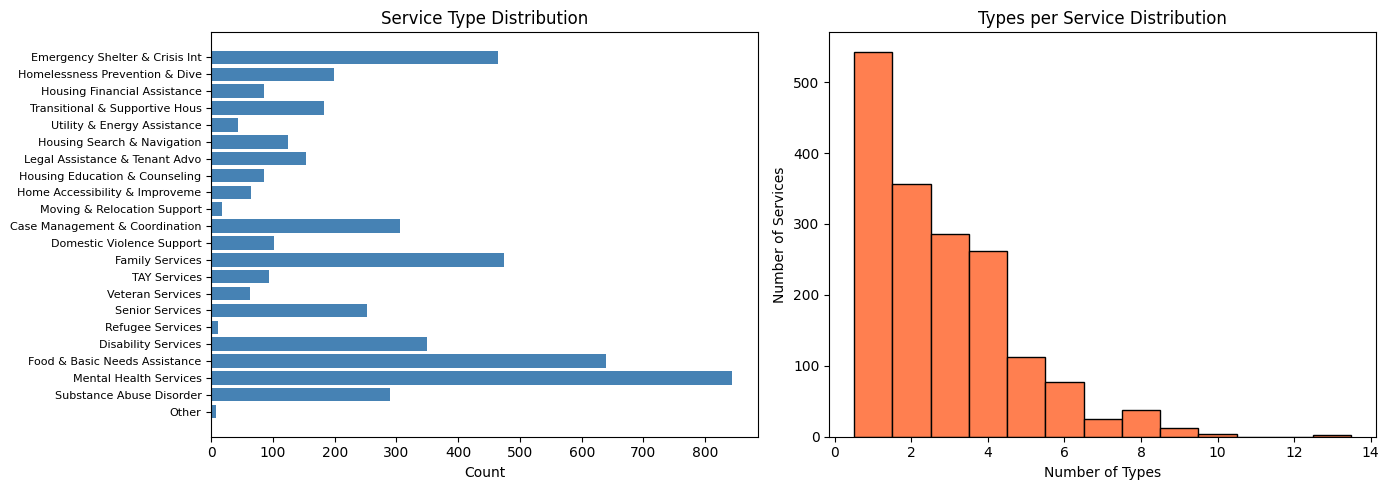

In [29]:
# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Type distribution
type_counts_ordered = [type_counts.get(t, 0) for t in SERVICE_TYPES]
axes[0].barh(range(NUM_LABELS), type_counts_ordered, color='steelblue')
axes[0].set_yticks(range(NUM_LABELS))
axes[0].set_yticklabels([t[:30] for t in SERVICE_TYPES], fontsize=8)
axes[0].set_xlabel('Count')
axes[0].set_title('Service Type Distribution')
axes[0].invert_yaxis()

# Types per service histogram
axes[1].hist(types_per_service, bins=range(1, max(types_per_service)+2), 
             color='coral', edgecolor='black', align='left')
axes[1].set_xlabel('Number of Types')
axes[1].set_ylabel('Number of Services')
axes[1].set_title('Types per Service Distribution')

plt.tight_layout()
plt.show()

## Prepare Data for Multi-Label Classification

In [30]:
def create_classification_text(row):
    """
    Combine relevant fields into text for classification.
    We exclude 'types' since that's what we're predicting!
    """
    parts = []
    
    # Service name
    if row.get('service_name') and str(row['service_name']) != 'nan':
        parts.append(f"Service: {row['service_name']}")
    
    # Description (most important)
    if row.get('description') and str(row['description']) != 'nan':
        parts.append(f"Description: {row['description']}")
    
    # Eligibility
    if row.get('eligibility') and str(row['eligibility']) != 'nan':
        parts.append(f"Eligibility: {row['eligibility']}")
    
    # Target populations
    target_val = row.get('target_populations')
    if target_val:
        if isinstance(target_val, list):
            target_str = ", ".join(str(t) for t in target_val)
        else:
            target_str = str(target_val)
        if target_str and target_str != 'nan':
            parts.append(f"Target: {target_str}")
    
    return " ".join(parts)


def create_multi_label_vector(types_list):
    """
    Convert a list of type strings to a binary vector.
    """
    vector = [0.0] * NUM_LABELS
    if isinstance(types_list, list):
        for t in types_list:
            if t in label2id:
                vector[label2id[t]] = 1.0
    return vector


# Create text and labels
df['text'] = df.apply(create_classification_text, axis=1)
df['labels'] = df['types'].apply(create_multi_label_vector)

print(f"Created text and labels for {len(df)} services")
print(f"\nSample text (first 300 chars):")
print(df['text'].iloc[0][:300] + "...")
print(f"\nSample labels vector: {df['labels'].iloc[0]}")
print(f"Sample types: {df['types'].iloc[0]}")

Created text and labels for 1719 services

Sample text (first 300 chars):
Service: Interim Shelter Bed Program (ISB) Description: Offers an interim shelter program that provides shelter for homeless youth who need a bed and food in a trauma-informed environment. 

Offers the following once enlisted: 
•	Food
•	Hygiene supplies
•	Clothing 
•	Transitional housing
•	Job searc...

Sample labels vector: [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]
Sample types: ['Case Management & Coordination', 'TAY Services', 'Mental Health Services', 'Transitional & Supportive Housing', 'Emergency Shelter & Crisis Intervention', 'Homelessness Prevention & Diversion', 'Food & Basic Needs Assistance', 'Substance Abuse Disorder']


In [31]:
# Verify label encoding
sample_idx = 0
print(f"Service: {df['service_name'].iloc[sample_idx]}")
print(f"\nOriginal types: {df['types'].iloc[sample_idx]}")
print(f"\nEncoded labels (non-zero):")
for i, val in enumerate(df['labels'].iloc[sample_idx]):
    if val == 1.0:
        print(f"  [{i}] {id2label[i]}")

Service: Interim Shelter Bed Program (ISB)

Original types: ['Case Management & Coordination', 'TAY Services', 'Mental Health Services', 'Transitional & Supportive Housing', 'Emergency Shelter & Crisis Intervention', 'Homelessness Prevention & Diversion', 'Food & Basic Needs Assistance', 'Substance Abuse Disorder']

Encoded labels (non-zero):
  [0] Emergency Shelter & Crisis Intervention
  [1] Homelessness Prevention & Diversion
  [3] Transitional & Supportive Housing
  [10] Case Management & Coordination
  [13] TAY Services
  [18] Food & Basic Needs Assistance
  [19] Mental Health Services
  [20] Substance Abuse Disorder


## Train/Test Split

In [32]:
from sklearn.model_selection import train_test_split

# Split the data (80/20)
train_df, test_df = train_test_split(
    df[['text', 'labels', 'types', 'service_name']],
    test_size=0.2,
    random_state=42
)

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Check label distribution in train set
train_label_counts = np.array(train_df['labels'].tolist()).sum(axis=0)
print("\nTraining set label counts:")
for i, count in enumerate(train_label_counts):
    print(f"  {int(count):4d} - {id2label[i][:40]}")

Training set: 1375 samples
Test set: 344 samples

Training set label counts:
   377 - Emergency Shelter & Crisis Intervention
   158 - Homelessness Prevention & Diversion
    70 - Housing Financial Assistance
   139 - Transitional & Supportive Housing
    34 - Utility & Energy Assistance
    95 - Housing Search & Navigation
   122 - Legal Assistance & Tenant Advocacy
    72 - Housing Education & Counseling
    56 - Home Accessibility & Improvement
    12 - Moving & Relocation Support
   248 - Case Management & Coordination
    87 - Domestic Violence Support
   393 - Family Services
    80 - TAY Services
    50 - Veteran Services
   200 - Senior Services
     8 - Refugee Services
   280 - Disability Services
   511 - Food & Basic Needs Assistance
   680 - Mental Health Services
   229 - Substance Abuse Disorder
     4 - Other


## Create Hugging Face Datasets

In [33]:
from datasets import Dataset, DatasetDict

# Prepare data for HF datasets
train_data = {
    'text': train_df['text'].tolist(),
    'labels': train_df['labels'].tolist()
}
test_data = {
    'text': test_df['text'].tolist(),
    'labels': test_df['labels'].tolist()
}

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1375
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 344
    })
})


## Tokenize with DistilBERT

In [34]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Loaded tokenizer: {model_name}")
print(f"Max length: {tokenizer.model_max_length}")

Loaded tokenizer: distilbert-base-uncased
Max length: 512


In [35]:
def tokenize_function(examples):
    """Tokenize text for the model."""
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512
    )

# Tokenize
tokenized_dataset = dataset.map(tokenize_function, batched=True)

print("Tokenized dataset:")
print(tokenized_dataset)

Map:   0%|          | 0/1375 [00:00<?, ? examples/s]

Map:   0%|          | 0/344 [00:00<?, ? examples/s]

Tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1375
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 344
    })
})


In [36]:
# Verify a sample
sample = tokenized_dataset['train'][0]
print(f"Keys: {sample.keys()}")
print(f"Input IDs length: {len(sample['input_ids'])}")
print(f"Labels shape: {len(sample['labels'])} (should be {NUM_LABELS})")
print(f"Labels sum: {sum(sample['labels'])} types assigned")

Keys: dict_keys(['text', 'labels', 'input_ids', 'attention_mask'])
Input IDs length: 512
Labels shape: 22 (should be 22)
Labels sum: 1.0 types assigned


## Load Model for Multi-Label Classification

In [37]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification"  # Key setting for multi-label!
)

print(f"Model loaded for multi-label classification")
print(f"Number of labels: {NUM_LABELS}")
print(f"Problem type: {model.config.problem_type}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded for multi-label classification
Number of labels: 22
Problem type: multi_label_classification


## Define Training Configuration

In [38]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss

def compute_metrics(eval_pred):
    """
    Compute multi-label classification metrics.
    """
    predictions, labels = eval_pred
    
    # Apply sigmoid and threshold
    sigmoid = 1 / (1 + np.exp(-predictions))
    preds_binary = (sigmoid > 0.5).astype(int)
    labels_binary = labels.astype(int)
    
    return {
        'f1_micro': f1_score(labels_binary, preds_binary, average='micro', zero_division=0),
        'f1_macro': f1_score(labels_binary, preds_binary, average='macro', zero_division=0),
        'f1_weighted': f1_score(labels_binary, preds_binary, average='weighted', zero_division=0),
        'precision_micro': precision_score(labels_binary, preds_binary, average='micro', zero_division=0),
        'recall_micro': recall_score(labels_binary, preds_binary, average='micro', zero_division=0),
        'hamming_loss': hamming_loss(labels_binary, preds_binary),
    }

print("Metrics function ready!")

Metrics function ready!


In [39]:
# Training arguments
training_args = TrainingArguments(
    output_dir='../models/service_type_classifier',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Smaller batch for multi-label
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # More epochs for multi-label
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_micro',
    logging_dir='../logs',
    logging_steps=50,
    report_to='none',
    fp16=False,  # Set to True if you have GPU with fp16 support
)

print("Training configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")

Training configuration:
  Epochs: 5
  Batch size: 8
  Learning rate: 2e-05


In [40]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Trainer ready!")

Trainer ready!


## Train the Model

This will take longer than single-label (more epochs, more complex task).

In [41]:
# Train!
print("Starting training...")
print("=" * 50)

train_result = trainer.train()

print("\n" + "=" * 50)
print("Training complete!")
print(f"Training time: {train_result.metrics['train_runtime']:.1f} seconds")

Starting training...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,Precision Micro,Recall Micro,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.314400,0.287913,0.421374,0.092048,0.290845,0.756164,0.292063,0.100159,2.611200,131.741000,16.468000
2,0.264300,0.227037,0.520568,0.175123,0.422773,0.887755,0.368254,0.084699,2.676300,128.533000,16.067000
3,0.206800,0.198875,0.623482,0.251779,0.534645,0.860335,0.488889,0.073732,2.677800,128.465000,16.058000
4,0.187600,0.184513,0.651774,0.289988,0.572895,0.859619,0.524868,0.070032,2.797500,122.969000,15.371000
5,0.174100,0.180487,0.667529,0.312745,0.597028,0.858569,0.546032,0.067918,3.008200,114.355000,14.294000



Training complete!
Training time: 206.3 seconds


## Evaluate the Model

In [42]:
# Evaluate on test set
eval_results = trainer.evaluate()

print("Evaluation Results:")
print("=" * 50)
print(f"F1 Micro:      {eval_results['eval_f1_micro']:.4f}")
print(f"F1 Macro:      {eval_results['eval_f1_macro']:.4f}")
print(f"F1 Weighted:   {eval_results['eval_f1_weighted']:.4f}")
print(f"Precision:     {eval_results['eval_precision_micro']:.4f}")
print(f"Recall:        {eval_results['eval_recall_micro']:.4f}")
print(f"Hamming Loss:  {eval_results['eval_hamming_loss']:.4f}")

Evaluation Results:
F1 Micro:      0.6675
F1 Macro:      0.3127
F1 Weighted:   0.5970
Precision:     0.8586
Recall:        0.5460
Hamming Loss:  0.0679


In [43]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# Get predictions
predictions = trainer.predict(tokenized_dataset['test'])
sigmoid = 1 / (1 + np.exp(-predictions.predictions))
pred_labels = (sigmoid > 0.5).astype(int)
true_labels = np.array(predictions.label_ids).astype(int)

# Per-label metrics
print("Per-Label Classification Report:")
print("=" * 70)
print(classification_report(
    true_labels, 
    pred_labels, 
    target_names=[t[:35] for t in SERVICE_TYPES],
    zero_division=0
))

Per-Label Classification Report:
                                     precision    recall  f1-score   support

Emergency Shelter & Crisis Interven       0.71      0.70      0.71        87
Homelessness Prevention & Diversion       0.92      0.54      0.68        41
       Housing Financial Assistance       0.00      0.00      0.00        15
  Transitional & Supportive Housing       1.00      0.07      0.13        43
        Utility & Energy Assistance       0.00      0.00      0.00         9
        Housing Search & Navigation       1.00      0.07      0.13        29
 Legal Assistance & Tenant Advocacy       1.00      0.19      0.32        32
     Housing Education & Counseling       0.00      0.00      0.00        14
   Home Accessibility & Improvement       0.00      0.00      0.00         8
        Moving & Relocation Support       0.00      0.00      0.00         5
     Case Management & Coordination       0.82      0.54      0.65        57
          Domestic Violence Support       

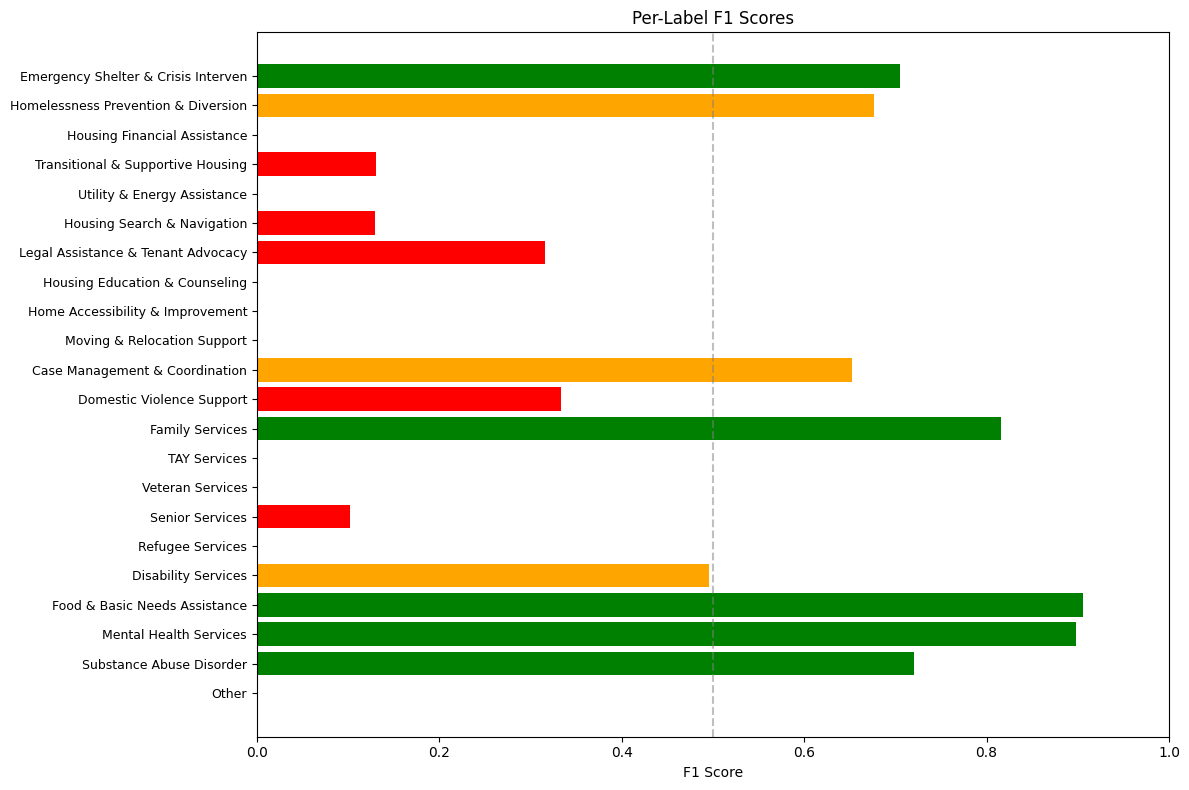


Labels sorted by F1 score:
  0.906 - Food & Basic Needs Assistance
  0.898 - Mental Health Services
  0.816 - Family Services
  0.720 - Substance Abuse Disorder
  0.705 - Emergency Shelter & Crisis Intervention
  0.677 - Homelessness Prevention & Diversion
  0.653 - Case Management & Coordination
  0.495 - Disability Services
  0.333 - Domestic Violence Support
  0.316 - Legal Assistance & Tenant Advocacy
  0.130 - Transitional & Supportive Housing
  0.129 - Housing Search & Navigation
  0.102 - Senior Services
  0.000 - Veteran Services
  0.000 - TAY Services
  0.000 - Refugee Services
  0.000 - Moving & Relocation Support
  0.000 - Home Accessibility & Improvement
  0.000 - Housing Education & Counseling
  0.000 - Utility & Energy Assistance
  0.000 - Housing Financial Assistance
  0.000 - Other


In [44]:
# Visualize per-label F1 scores
from sklearn.metrics import f1_score

per_label_f1 = []
for i in range(NUM_LABELS):
    f1 = f1_score(true_labels[:, i], pred_labels[:, i], zero_division=0)
    per_label_f1.append(f1)

# Plot
plt.figure(figsize=(12, 8))
colors = ['green' if f1 > 0.7 else 'orange' if f1 > 0.4 else 'red' for f1 in per_label_f1]
bars = plt.barh(range(NUM_LABELS), per_label_f1, color=colors)
plt.yticks(range(NUM_LABELS), [t[:35] for t in SERVICE_TYPES], fontsize=9)
plt.xlabel('F1 Score')
plt.title('Per-Label F1 Scores')
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print sorted by F1
print("\nLabels sorted by F1 score:")
sorted_indices = np.argsort(per_label_f1)[::-1]
for idx in sorted_indices:
    print(f"  {per_label_f1[idx]:.3f} - {SERVICE_TYPES[idx]}")

## Save the Model

In [45]:
# Save the fine-tuned model
model_path = '../models/service_type_classifier_final'
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

# Also save the label mappings
import json
with open(f'{model_path}/label_mappings.json', 'w') as f:
    json.dump({
        'label2id': label2id,
        'id2label': id2label,
        'service_types': SERVICE_TYPES
    }, f, indent=2)

print(f"Model saved to: {model_path}")

Model saved to: ../models/service_type_classifier_final


## Use the Classifier

In [46]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def load_classifier(model_path):
    """Load the trained multi-label classifier."""
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()
    return model, tokenizer

# Load
clf_model, clf_tokenizer = load_classifier(model_path)
print("Classifier loaded!")

Classifier loaded!


In [47]:
def classify_service(text, threshold=0.5, top_k=None, verbose=True):
    """
    Classify a service description and return predicted types.
    
    Args:
        text: Service description text
        threshold: Probability threshold for positive prediction (default 0.5)
        top_k: If set, return top k predictions regardless of threshold
        verbose: Print results
    
    Returns:
        List of (type_name, probability) tuples
    """
    # Tokenize
    inputs = clf_tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        padding=True
    )
    
    # Predict
    with torch.no_grad():
        outputs = clf_model(**inputs)
        probs = torch.sigmoid(outputs.logits).squeeze().numpy()
    
    # Get predictions
    results = [(SERVICE_TYPES[i], float(probs[i])) for i in range(NUM_LABELS)]
    results = sorted(results, key=lambda x: x[1], reverse=True)
    
    if top_k:
        predictions = results[:top_k]
    else:
        predictions = [(t, p) for t, p in results if p >= threshold]
    
    if verbose:
        print("Predicted Service Types:")
        print("-" * 60)
        for type_name, prob in predictions:
            bar = "*" * int(prob * 40)
            print(f"  {prob:.3f} {type_name[:40]:40} {bar}")
        
        if not predictions:
            print("  (No types above threshold)")
            print("  Top 3 closest:")
            for type_name, prob in results[:3]:
                print(f"    {prob:.3f} {type_name}")
    
    return predictions

In [48]:
# Test examples
print("Test 1: Emergency shelter for veterans")
print("=" * 70)
test1 = """Emergency overnight shelter for homeless veterans. 
Provides beds, meals, and case management. Must show DD-214.
Mental health counseling available on-site."""
classify_service(test1)

print("\n\nTest 2: Food pantry")
print("=" * 70)
test2 = """Free food distribution every Saturday. Fresh produce, 
canned goods, and bread available. No ID required. 
Serves families in the downtown area."""
classify_service(test2)

print("\n\nTest 3: Transitional housing with services")
print("=" * 70)
test3 = """Transitional housing program for families experiencing homelessness.
Up to 24 months stay. Includes case management, job training,
financial literacy classes, and help finding permanent housing."""
classify_service(test3)

Test 1: Emergency shelter for veterans
Predicted Service Types:
------------------------------------------------------------
  0.540 Emergency Shelter & Crisis Intervention  *********************


Test 2: Food pantry
Predicted Service Types:
------------------------------------------------------------
  0.918 Food & Basic Needs Assistance            ************************************


Test 3: Transitional housing with services
Predicted Service Types:
------------------------------------------------------------
  (No types above threshold)
  Top 3 closest:
    0.440 Transitional & Supportive Housing
    0.424 Emergency Shelter & Crisis Intervention
    0.420 Homelessness Prevention & Diversion


[]

## Integration with RAG Pipeline

In [49]:
def classify_query_intent(query, threshold=0.3):
    """
    Classify a user query to understand what types of services they need.
    Uses a lower threshold since queries are shorter and less specific.
    """
    print(f"Query: {query}")
    print("-" * 60)
    
    predictions = classify_service(query, threshold=threshold, verbose=False)
    
    if predictions:
        print("Detected service needs:")
        for type_name, prob in predictions:
            print(f"  [{prob:.2f}] {type_name}")
    else:
        print("No specific service types detected. Showing general results.")
    
    return [t for t, p in predictions]

# Test with queries
print("\nQuery Intent Classification:")
print("=" * 70)

queries = [
    "I need help paying my rent this month",
    "Where can a homeless veteran get a bed tonight?",
    "Senior citizen needs help with food and utilities",
    "Young adult aging out of foster care needs housing"
]

for q in queries:
    print()
    classify_query_intent(q)
    print()


Query Intent Classification:

Query: I need help paying my rent this month
------------------------------------------------------------
Detected service needs:
  [0.47] Food & Basic Needs Assistance


Query: Where can a homeless veteran get a bed tonight?
------------------------------------------------------------
Detected service needs:
  [0.47] Food & Basic Needs Assistance


Query: Senior citizen needs help with food and utilities
------------------------------------------------------------
Detected service needs:
  [0.89] Food & Basic Needs Assistance


Query: Young adult aging out of foster care needs housing
------------------------------------------------------------
Detected service needs:
  [0.41] Transitional & Supportive Housing
  [0.32] Senior Services



## Analyze Model Performance

In [50]:
# Check some predictions vs actual
print("Sample Predictions vs Actual:")
print("=" * 70)

for i in range(5):
    row = test_df.iloc[i]
    
    print(f"\nService: {row['service_name'][:60]}")
    
    # Actual types
    actual = row['types'] if isinstance(row['types'], list) else []
    print(f"Actual types: {actual}")
    
    # Predicted types
    preds = classify_service(row['text'], threshold=0.5, verbose=False)
    pred_types = [t for t, p in preds]
    print(f"Predicted:    {pred_types}")
    
    # Check overlap
    overlap = set(actual) & set(pred_types)
    print(f"Overlap: {len(overlap)}/{len(actual)} correct")
    print("-" * 70)

Sample Predictions vs Actual:

Service: Free Meal Program, Third Avenue Charitable Organization
Actual types: ['Food & Basic Needs Assistance']
Predicted:    ['Food & Basic Needs Assistance']
Overlap: 1/1 correct
----------------------------------------------------------------------

Service: Vision Rehabilitation Courses, San Diego
Actual types: ['Disability Services', 'Mental Health Services']
Predicted:    ['Mental Health Services']
Overlap: 1/2 correct
----------------------------------------------------------------------

Service: Community Supports, Housing Transition Navigation Services
Actual types: ['Case Management & Coordination', 'Housing Search & Navigation', 'Mental Health Services', 'Legal Assistance & Tenant Advocacy', 'Housing Education & Counseling', 'Emergency Shelter & Crisis Intervention', 'Homelessness Prevention & Diversion']
Predicted:    ['Homelessness Prevention & Diversion', 'Case Management & Coordination', 'Disability Services', 'Emergency Shelter & Crisis 

## Summary

You now have a **multi-label service type classifier** that:

1. **Predicts multiple service types** per service (up to 22 types)
2. **Returns confidence scores** for each type
3. **Can classify user queries** to understand their needs
4. **Integrates with RAG pipeline** for filtering/ranking results

### Key Metrics
- **F1 Micro**: Overall accuracy across all labels
- **F1 Macro**: Average performance per label (treats rare labels equally)
- **Hamming Loss**: Fraction of wrong labels (lower is better)

### Next Steps

| Enhancement | Description |
|-------------|-------------|
| Threshold Tuning | Optimize per-label thresholds for better precision/recall |
| Class Weighting | Handle imbalanced labels (e.g., 'Refugee Services' is rare) |
| Hierarchical Classification | Group related types for better predictions |
| Active Learning | Improve model with user corrections |